In [ ]:
#@title Install dependencies
!pip install -q datasets

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
#@title Check GPU
device_name = tf.test.gpu_device_name()
if device_name:
    print("✅ GPU available:", device_name)
else:
    print("⚠️ No GPU detected. Training will still work, but slower.")


⚠️ No GPU detected. Training will still work, but slower.


In [ ]:
#@title Load Enron-Spam dataset

dataset = load_dataset("SetFit/enron_spam")

print(dataset)
print("Train size:", len(dataset["train"]))
print("Test size:", len(dataset["test"]))

# Convert to pandas for easier inspection / plotting
train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

train_df.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/176 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/101M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/6.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31716 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 31716
    })
    test: Dataset({
        features: ['message_id', 'text', 'label', 'label_text', 'subject', 'message', 'date'],
        num_rows: 2000
    })
})
Train size: 31716
Test size: 2000


,message_id,text,label,label_text,subject,message,date
0,33214,any software just for 15 $ - 99 $ understandin...,1,spam,any software just for 15 $ - 99 $,understanding oem software\nlead me not into t...,2005-06-18
1,11929,perspective on ferc regulatory action client c...,0,ham,perspective on ferc regulatory action client c...,"19 th , 2 : 00 pm edt\nperspective on ferc reg...",2001-06-19
2,19784,wanted to try ci 4 lis but thought it was way ...,1,spam,wanted to try ci 4 lis but thought it was way ...,viagra at $ 1 . 12 per dose\nready to boost yo...,2004-09-11
3,2209,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,"enron / hpl actuals for december 11 , 2000",teco tap 30 . 000 / enron ; 120 . 000 / hpl ga...,2000-12-12
4,15880,looking for cheap high - quality software ? ro...,1,spam,looking for cheap high - quality software ? ro...,"water past also , burn , course . gave country...",2005-02-13


label
1    16163
0    15553
Name: count, dtype: int64
label
1    0.509617
0    0.490383
Name: proportion, dtype: float64


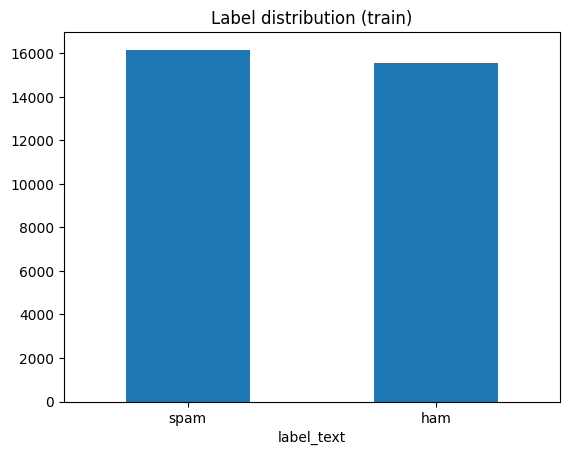

Example SPAM email:
any software just for 15 $ - 99 $ understanding oem software
lead me not into temptation ; i can find the way myself .
# 3533 . the law disregards trifles .

Example HAM email:
perspective on ferc regulatory action client conf call today , jun e 19 th , 2 : 00 pm edt
perspective on ferc regulatory action client conference call
today , tuesday , june 19 th
2 : 00 pm edt
host : ray niles , power / natural gas analyst
speaker : steve bergstrom , president & coo of dynegy
steve bergstrom , president and chief operating officer of dynegy , will join
us at 2 : 00 p . m . today for a conference call discussion of the recent ferc
action imposing price controls in the west . th


In [ ]:
#@title Explore label distribution

print(train_df["label"].value_counts())
print(train_df["label"].value_counts(normalize=True))

train_df["label_text"].value_counts().plot(kind="bar")
plt.title("Label distribution (train)")
plt.xticks(rotation=0)
plt.show()

print("Example SPAM email:")
print(train_df[train_df["label_text"] == "spam"]["text"].iloc[0][:500])

print("\nExample HAM email:")
print(train_df[train_df["label_text"] == "ham"]["text"].iloc[0][:500])


In [ ]:
#@title Create train / validation / test splits

split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_ds_hf = split["train"]
val_ds_hf = split["test"]
test_ds_hf = dataset["test"]

print("Train:", len(train_ds_hf))
print("Val:", len(val_ds_hf))
print("Test:", len(test_ds_hf))

# 🔧 FORCE into plain Python lists of strings
train_texts = list(train_ds_hf["text"])
val_texts   = list(val_ds_hf["text"])
test_texts  = list(test_ds_hf["text"])

train_labels = np.array(train_ds_hf["label"], dtype="int32")
val_labels   = np.array(val_ds_hf["label"], dtype="int32")
test_labels  = np.array(test_ds_hf["label"], dtype="int32")

# Quick check
print(type(train_texts), type(train_texts[0]))


Train: 25372
Val: 6344
Test: 2000
<class 'list'> <class 'str'>


In [ ]:
#@title Text vectorization

max_tokens = 20000  # vocabulary size (students can tune)
max_len    = 200    # sequence length (students can tune)

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_len,
)

# Adapt vectorizer on training texts
text_ds_for_adapt = tf.data.Dataset.from_tensor_slices(train_texts).batch(512)
vectorize_layer.adapt(text_ds_for_adapt)

# Quick test
sample = train_texts[0]
print("Raw text:", sample[:200])
print("Token IDs:", vectorize_layer(tf.constant([sample]))[0][:30])


Raw text: executive customer list if we can trouble you once again , steve needs , by the end of today , the
names and numbers of the key executives on the list attached . please
complete the name of the presid
Token IDs: tf.Tensor(
[ 555  498  202   33   20   43 3254    9  478  379  603  551   30    2
  335    5  181    2  785    4  481    5    2  792 1264   13    2  202
  238   41], shape=(30,), dtype=int64)


In [ ]:
#@title Build TensorFlow Datasets

batch_size = 64  # students can tune

def make_dataset(texts, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(texts), reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_texts, train_labels, training=True)
val_ds   = make_dataset(val_texts, val_labels, training=False)
test_ds  = make_dataset(test_texts, test_labels, training=False)

train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
#@title Define Transformer block

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim=10, num_heads=2, ff_dim=32, rate=0.1, **kwargs):
        # IMPORTANT: pass **kwargs to super() to accept 'trainable', 'dtype', etc.
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

        # key_dim is embed_dim // num_heads -> here 5
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
        )
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        # Let Keras know how to serialize our custom args
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "rate": self.rate,
            }
        )
        return config


In [ ]:
#@title Build 10-dimensional Transformer spam classifier

embed_dim = 10   # 🔴 requirement: 10-dimensional representation
num_heads = 2    # students can tune (must divide embed_dim)
ff_dim    = 32   # feed-forward size (students can tune)
dropout_rate = 0.2

# Input is raw text
text_input = layers.Input(shape=(), dtype=tf.string, name="text")

# Text -> token IDs
x = vectorize_layer(text_input)

# Token IDs -> embeddings (10-dimensional)
x = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embed_dim,
    name="token_embedding"
)(x)

# Transformer encoder
x = TransformerBlock(
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    rate=dropout_rate,
)(x)

# Reduce sequence to a single vector
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout_rate)(x)

# Output layer: spam (1) vs ham (0)
output = layers.Dense(1, activation="sigmoid", name="spam_score")(x)

model = keras.Model(inputs=text_input, outputs=output)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 200, 10)        │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 10)        │         1,162 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 10)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spam_score (Dense)              │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,173 (785.83 KB)

 Trainable params: 201,173 (785.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#@title Compile model

learning_rate = 1e-3  # students can tune

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
    ],
)


In [ ]:
#@title Train the Transformer model

epochs = 5  # students can tune

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)


Epoch 1/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 59s 130ms/step - accuracy: 0.8403 - auc: 0.9097 - loss: 0.3851 - val_accuracy: 0.9877 - val_auc: 0.9980 - val_loss: 0.0424
Epoch 2/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 80s 126ms/step - accuracy: 0.9895 - auc: 0.9986 - loss: 0.0366 - val_accuracy: 0.9918 - val_auc: 0.9986 - val_loss: 0.0297
Epoch 3/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 48s 120ms/step - accuracy: 0.9970 - auc: 0.9997 - loss: 0.0120 - val_accuracy: 0.9929 - val_auc: 0.9976 - val_loss: 0.0308
Epoch 4/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 83s 122ms/step - accuracy: 0.9989 - auc: 0.9996 - loss: 0.0066 - val_accuracy: 0.9912 - val_auc: 0.9957 - val_loss: 0.0415
Epoch 5/5
397/397 ━━━━━━━━━━━━━━━━━━━━ 81s 121ms/step - accuracy: 0.9997 - auc: 0.9999 - loss: 0.0031 - val_accuracy: 0.9920 - val_auc: 0.9959 - val_loss: 0.0406


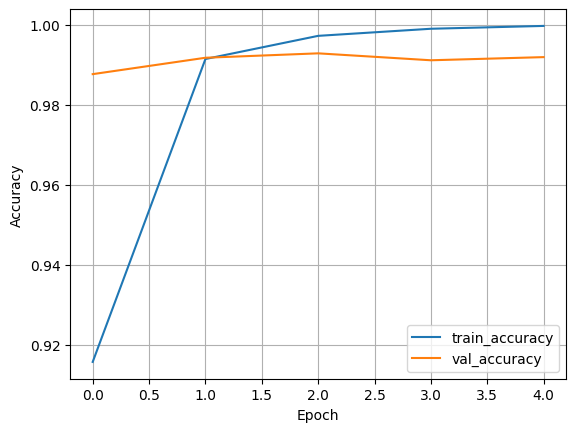

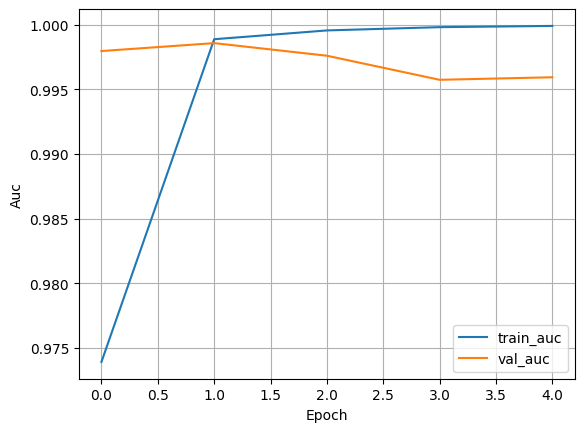

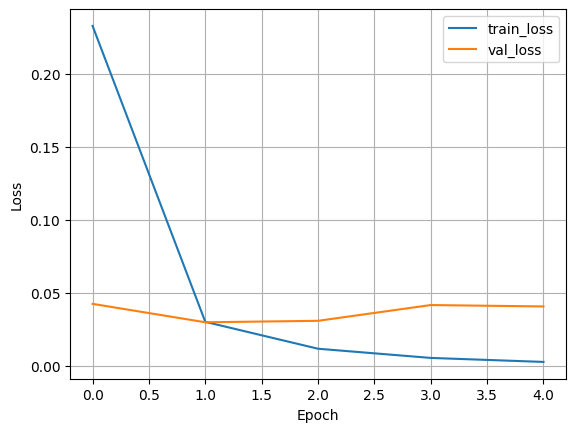

In [ ]:
#@title Plot training curves

def plot_history(history, metric="accuracy"):
    plt.figure()
    plt.plot(history.history[metric], label=f"train_{metric}")
    plt.plot(history.history[f"val_{metric}"], label=f"val_{metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history, "accuracy")
plot_history(history, "auc")
plot_history(history, "loss")


In [ ]:
#@title Evaluate on test set

test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Collect predictions for detailed metrics
test_texts_list = list(test_texts)
test_labels_array = np.array(test_labels)

pred_probs = model.predict(tf.constant(test_texts_list)).ravel()
pred_labels = (pred_probs >= 0.5).astype("int32")

print("\nClassification report:")
print(classification_report(test_labels_array, pred_labels, target_names=["ham", "spam"]))

print("\nConfusion matrix:")
print(confusion_matrix(test_labels_array, pred_labels))


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9885 - auc: 0.9951 - loss: 0.0591
Test loss: 0.0520
Test accuracy: 0.9895
Test AUC: 0.9958
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

Classification report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       992
        spam       0.99      0.99      0.99      1008

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


Confusion matrix:
[[ 979   13]
 [   8 1000]]


In [ ]:
#@title Save model to disk

save_path = "enron_spam_transformer.keras"

model.save(
    save_path,
    include_optimizer=True,
)

print("Model saved to:", save_path)


Model saved to: enron_spam_transformer.keras


In [ ]:
#@title Load saved model

loaded_model = keras.models.load_model(
    save_path,
    custom_objects={"TransformerBlock": TransformerBlock},
)

loaded_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'transformer_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text (InputLayer)               │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 200, 10)        │       200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 200, 10)        │         1,162 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 10)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spam_score (Dense)              │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,521 (2.30 MB)

 Trainable params: 201,173 (785.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 402,348 (1.53 MB)

In [ ]:
#@title Test the trained model with custom input

def classify_email(text, model=loaded_model):
    text_tensor = tf.constant([text])
    prob = model.predict(text_tensor)[0][0]
    label = "SPAM" if prob >= 0.5 else "HAM"
    print(f"Text: {text[:200]}{'...' if len(text) > 200 else ''}")
    print(f"Predicted label: {label}  (prob = {prob:.3f})")
    return prob, label

# Try some examples:
examples = [
    "Get cheap Viagra now!!! Limited offer, click here to buy.",
    "Hi team, the meeting is scheduled for tomorrow at 10 AM.",
    "You have won $1,000,000. Please send your bank details.",
    "Hi Marc, how are you doing? I hope this email finds you well.",
    "Hi, I have a super secret offer for you - 200% off of Clothes if you click this link",
]

for e in examples:
    print("=" * 80)
    classify_email(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: Get cheap Viagra now!!! Limited offer, click here to buy.
Predicted label: SPAM  (prob = 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Text: Hi team, the meeting is scheduled for tomorrow at 10 AM.
Predicted label: HAM  (prob = 0.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Text: You have won $1,000,000. Please send your bank details.
Predicted label: SPAM  (prob = 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Text: Hi Marc, how are you doing? I hope this email finds you well.
Predicted label: HAM  (prob = 0.364)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Text: Hi, I have a super secret offer for you - 200% off of Clothes if you click this link
Predicted label: SPAM  (prob = 1.000)
